In [427]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import sqlalchemy
import sqlalchemy_utils
import psycopg2

import pandas as pd
import numpy as np

import xml.etree.ElementTree as ET
import string
import re

import spacy
nlp = spacy.load('en_core_web_lg')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
# Connect to db wiht sqlalchemy
dbname = 'congressional_bills'
username = 'melissaferrari'
engine = sqlalchemy.create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://melissaferrari@localhost/congressional_bills


In [5]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

### Bill topics.

In [6]:
query = """
        SELECT subjects_top_term, COUNT(*) FROM bills GROUP BY subjects_top_term;
        """

top_subjects = pd.read_sql_query(query, engine)
top_subjects = top_subjects.set_index('subjects_top_term').sort_values(by='count', ascending=False)

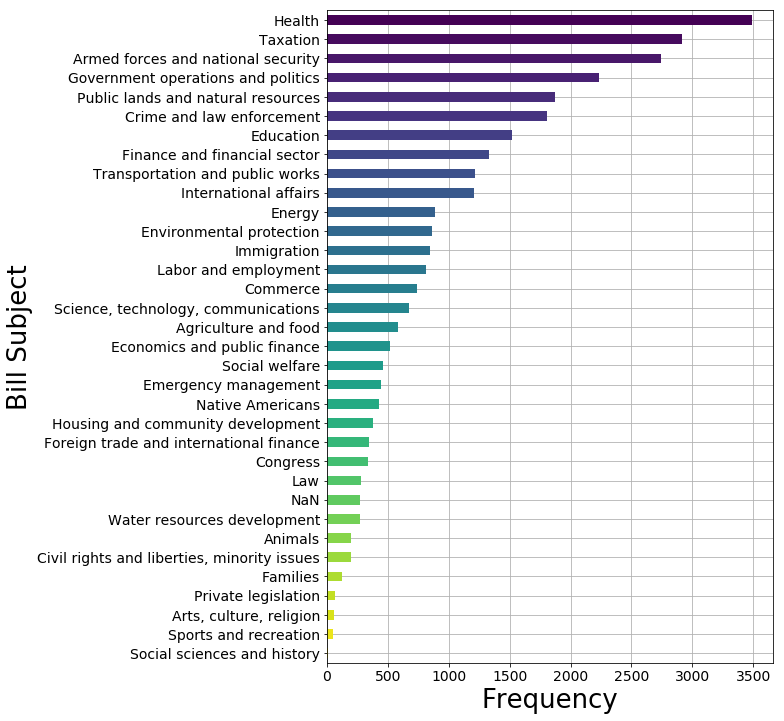

In [12]:
fig, ax = plt.subplots(figsize=(8, 12))
colors = matplotlib.cm.viridis_r(np.linspace(0, 1, len(top_subjects)))
top_subjects['count'].sort_values().plot(kind='barh', ax=ax, stacked=True, color=colors);
ax.grid(); ax.set_axisbelow(True); ax.set_ylabel('Bill Subject', size=26); ax.set_xlabel('Frequency', size=26);

In [13]:
top25 = top_subjects.nlargest(int(0.25*len(top_subjects)), 'count')
top25

,count
subjects_top_term,
Health,3490
Taxation,2915
Armed forces and national security,2741
Government operations and politics,2233
Public lands and natural resources,1876
Crime and law enforcement,1810
Education,1520
Finance and financial sector,1329


# Get tables from DB.

In [16]:
summary_table = pd.read_sql_table('summaries', con=engine, columns=None)
bills_info = pd.read_sql_table('bills', con=engine)
bills_text_table = pd.read_sql_table('bill_text', con=engine, columns=None)

In [14]:
query = """
        SELECT 
        sm.text AS summary_text,
        sm.bill_ix, sm.as, sm.date,
        bv.code,
        bt.text AS full_text
        FROM summaries sm
        INNER JOIN bill_text bt
        ON sm.bill_ix=bt.bill_ix
        INNER JOIN bill_versions bv
        ON bv.id=bt.bill_version_id
        ;
        """
bill_inner_join = pd.read_sql_query(query, engine)

In [15]:
bill_inner_join.head()

,summary_text,bill_ix,as,date,code,full_text
0,Consumer Financial Protection Commission Act o...,27059,Introduced in House,2013-06-17,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
1,Children of Military Service Members Commemora...,27062,Introduced in House,2013-05-08,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
2,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
3,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,RH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
4,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,EH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [19]:
subject = 'Education'
subject in list(top25.index.values)

True

In [20]:
select_cols = ['id', 'official_title', 'bill_type', 'status_at', 'sponsor', 'status', 
               'subjects_top_term', 'bill_id', 'introduced_at', 'congress', 'short_title']
ed_bills = bills_info[bills_info['subjects_top_term'] == subject][select_cols]
ed_bills = ed_bills.rename(columns={'id':'bill_ix'})
len(ed_bills)

1520

In [21]:
ed_bills_join = ed_bills.merge(bill_inner_join, on='bill_ix', how='inner')
len(ed_bills_join)

1168

In [23]:
duplicates = ed_bills_join[ed_bills_join.duplicated('bill_ix')].bill_ix.unique()

### If bill search returns multiple versions of the same bill.

In [39]:
def _return_correct_bill_version(df):
    num_rows = len(df)
    if num_rows == 0:
        raise Exception('Oh no! This bill is not in the database.')
    elif num_rows > 1:
        rank_codes = ['ENR', 'EAS', 'EAH', 'RS', 'ES', 'PCS', 'EH', 'RH', 'IS', 'IH']
        code = next(i for i in rank_codes if i in df['code'].unique())
        df = df[df['code'] == code]
    return df.iloc[0].to_dict()

def _check_if_unfavorable_bill(bill_dict):
    if 'to amend the' in bill_dict['official_title'].lower():
        print('this is an ammendment, proceed wiht caution')
        return True

In [177]:
def _check_if_unfavorable_bill(bill_dict):
    if 'to amend the' in bill_dict['official_title'].lower():
        print('this is an ammendment, proceed wiht caution')
        return True

In [187]:
ix = 2
test_bill = ed_bills_join[(ed_bills_join['bill_ix']==duplicates[ix])].copy()

In [188]:
test_bill = _return_correct_bill_version(test_bill)

In [189]:
is_bad = _check_if_bad(test_bill)
is_bad

this is an ammendment, proceed wiht caution


True

In [199]:
test_bill['bill_id']

'hr3179-114'

In [357]:
short_title = test_bill['short_title']
official_title = test_bill['official_title']
print(short_title)
print(official_title)

Empowering Students Through Enhanced Financial Counseling Act
To amend the loan counseling requirements under the Higher Education Act of 1965, and for other purposes.


## Clean text.

In [205]:
def _is_not_empty(maybe_text):
    if maybe_text and not maybe_text.isspace():
        return True

In [206]:
txt_tree = ET.ElementTree(ET.fromstring(test_bill['full_text']))
txt_root = txt_tree.getroot()
txt_descendants = list(txt_root.iter())
txt_extract = [[ix, elem.tag, elem.text] for ix, elem in enumerate(txt_root.iter()) 
               if _is_not_empty(elem.text)] #and elem.tag in ['enum', 'header', 'text']]

In [209]:
def _clean_extracted_list(txt_extract, unwanted_tags=['external-xref', 'after-quoted-block']):
    txt_extract = pd.DataFrame(txt_extract)
    txt_extract.columns = ['loc_ix', 'tag', 'text']
    
    first_ix = txt_extract.index[txt_extract['tag'] == 'short-title'].tolist()[0]
    last_ix = txt_extract.index[txt_extract['tag'] == 'attestation-date'].tolist()[0] -1
    txt_extract = txt_extract.loc[first_ix:last_ix]

    return txt_extract[~txt_extract['tag'].isin(unwanted_tags)]

In [210]:
txt_extract = _clean_extracted_list(txt_extract)

In [255]:
def _full_text_tostring(txt_extract, omit_tags=['header', 'short-title']):
    sentences = []
    enum_string = ""
    full_string = ""
    for ix, row in txt_extract[~txt_extract['tag'].isin(omit_tags)].iterrows():
        nextix = ix
        enum_string += row['text'] + ' '
        if row['tag'] == 'enum':
            nextix = ix + 1
        if nextix == ix:
            sentences.append(row['text'] + ' ')
            full_string += row['text'] + ' '
    return full_string, enum_string, sentences

In [270]:
full_string, enum_string, extract_sentences = _full_text_tostring(txt_extract)

In [278]:
def _tokenize_sentences(txt_string):
    doc = nlp(txt_string)
    txt_sent = [sent.string.strip() for sent in doc.sents]
    return doc, txt_sent

In [524]:
full_doc, full_sent = _tokenize_sentences(full_string)

In [525]:
def _remove_whitespace(sentence_list):
    
    white_space = list(string.whitespace)[1:]
    for ix in range(len(sentence_list)):
        for bad_string in white_space:
            if bad_string in sentence_list[ix]:
                sentence_list[ix] = sentence_list[ix].replace(bad_string, "")
    
    return sentence_list                

In [526]:
full_sent_clean = full_sent

full_sent_clean = _remove_custom(full_sent_clean, type='sec')
full_sent_clean = _remove_whitespace(full_sent_clean)
full_sent_clean =  _remove_punct_nums(full_sent_clean)
full_sent_clean = _make_lowercase(full_sent_clean)

full_sent_clean = [s for s in full_sent_clean if _is_not_empty(s)]

In [306]:
def _extract_entities(sentences, bad_ents=['WORK_OF_ART', 'CARDINAL']):

    df_ent = pd.DataFrame()
    for ix, sentence in enumerate(sentences):
        doc = nlp(sentence)
        for ent in doc.ents:

            df_ent = df_ent.append([[ix, ent.text, ent.start_char,
                                     ent.end_char, ent.label_]], ignore_index=True)

    df_ent.columns = ['sentence', 'text', 'start_char', 'end_char', 'label']
    df_ent = df_ent[(~df_ent.label.isin(bad_ents))& (~df_ent['text'].apply(str.isspace))]

    return df_ent

In [307]:
df_ent = _extract_entities(full_sent)

In [309]:
df_ent.groupby(['label']).size()

label
DATE       29
LAW        13
MONEY       1
NORP        1
ORDINAL     3
ORG        37
PERSON      4
PRODUCT     2
dtype: int64

### IMPORTANT NOTE WRT ORDERED LISTS:
Here I chose to go with the spacy tokenized version of `full_string` rather than `extracted_sentences` because they put all bullet points in one block.

#### Get word embeddings.

In [195]:
def _extract_embeddings(path_to_embedding = '../nlp_models/glove.6B/glove.6B.300d.txt'):
    f = open(path_to_embedding, encoding='utf-8')
    word_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    embedding_size = coefs.shape
    return word_embeddings, embedding_size 

In [196]:
#word_embeddings, embedding_size = _extract_embeddings()

In [336]:
def _calc_embedding(sen, word_embeddings, embedding_size):
    if embedding_size == None:
        embedding_size = random.choice(list(word_embeddings.values())).shape
    if len(sen) != 0:
        vector = sum([word_embeddings.get(w, np.zeros(embedding_size)) for w in sen.split()])/(len(sen.split())+0.001)
    else:
        vector = np.zeros(embedding_size)
    return vector

In [529]:
full_vec = [_calc_embedding(s, word_embeddings, embedding_size) for s in full_sent_clean]

### Prepare summary.

In [478]:
def _remove_punct_nums(sentences):
    # remove punctuations, numbers and special characters
    regex = re.compile(r"[^a-zA-Z]")
    return [regex.sub(" ", s) for s in sentences]

def _make_lowercase(sentences):
    return [s.lower() for s in sentences]

def _remove_custom(sentence_list, type='sec'):

    for ix in range(len(sentence_list)):
        s = sentence_list[ix]
        start_ix = s.find("(Sec.")
        if start_ix != -1:
            end_ix = start_ix + 8
            sentence_list[ix] = sentence_list[ix].replace(s[start_ix:end_ix], " ")
    
    return sentence_list                

In [484]:
summ_string = test_bill['summary_text']
summ_doc, summ_sent = _tokenize_sentences(summ_string)

In [501]:
summ_sent_clean = summ_sent

summ_sent_clean = _remove_custom(summ_sent_clean, type='sec')
summ_sent_clean = _remove_whitespace(summ_sent)
summ_sent_clean =  _remove_punct_nums(summ_sent_clean)
summ_sent_clean = _make_lowercase(summ_sent_clean)

summ_sent_clean = [s for s in summ_sent_clean if _is_not_empty(s)]

In [502]:
summ_vec = [_calc_embedding(s, word_embeddings, embedding_size) for s in summ_sent_clean]

### Match summary.

In [531]:
def _create_sim_mat(sent_vecs_1, sent_vecs_2):
    sim_mat = np.zeros([len(sent_vecs_1), len(sent_vecs_2)])
    veclen = list(embedding_size)[0]
    for i in range(len(sent_vecs_1)):
        for j in range(len(sent_vecs_2)):
            sim_mat[i][j] = metrics.pairwise.cosine_similarity(sent_vecs_1[i].reshape(1,veclen), 
                                              sent_vecs_2[j].reshape(1,veclen))[0,0]
    return sim_mat

In [638]:
sim_mat.shape

(49, 11)

In [507]:
from sklearn import metrics

In [591]:
sim_mat = _create_sim_mat(full_vec, summ_vec)

In [642]:
ix_sort = (-sim_mat).argsort(axis=0)[:1]

In [643]:
ix_sort

array([[ 6,  0, 18, 39,  0, 24,  0, 18, 39, 42, 47]])

In [603]:
ix_sort = (-sim_mat).argsort(axis=0)[:1][0]
ix_match = np.sort(ix_sort)
ix_match = np.unique(ix_match)

In [604]:
ix_match

array([ 0,  6, 18, 24, 39, 42, 47])

**first pass:** Just choose not duplicates.

In [605]:
closest_match = [full_sent[i] for i in ix_match]

In [606]:
closest_match

['Section 485(l) of the Higher Education Act of 1965 ( Each eligible institution shall ensure that each individual who receives a Federal Pell Grant or a loan made under part D (other than a Federal Direct Consolidation Loan) receives comprehensive information on the terms and conditions of such Federal Pell Grant or loan and the responsibilities the individual has with respect to such Federal Pell Grant or loan.',
 'An introduction to the financial management resources provided by the Financial Literacy and Education Commission.',
 'A recommendation to the borrower to exhaust the borrower’s Federal student loan options prior to taking out private education loans, an explanation that Federal student loans typically offer better terms and conditions than private education loans, an explanation of treatment of loans made under part D and private education loans in bankruptcy, and an explanation that if a borrower decides to take out a private education loan— the borrower has the ability 

In [621]:
ed_bills.shape

(1520, 11)

In [623]:
ed_bills_join.columns

Index(['bill_ix', 'official_title', 'bill_type', 'status_at', 'sponsor',
       'status', 'subjects_top_term', 'bill_id', 'introduced_at', 'congress',
       'short_title', 'summary_text', 'as', 'date', 'code', 'full_text'],
      dtype='object')

In [624]:
ed_bills_join[['summary_text', 'full_text']].head()

,summary_text,full_text
0,Pell Grant Funding Act\n\nDirects the Secretar...,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
1,Assessing Appropriate School Start Times Act\n...,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
2,Helping Schools Protect Our Children Act of 20...,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
3,Online Education Verification Act\n\nAmends ti...,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
4,All Children are Equal Act or the ACE Act\n\nA...,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [627]:
len(full_vec)

49

In [632]:
full_sent_clean[0]

'section     l  of the higher education act of        each eligible institution shall ensure that each individual who receives a federal pell grant or a loan made under part d  other than a federal direct consolidation loan  receives comprehensive information on the terms and conditions of such federal pell grant or loan and the responsibilities the individual has with respect to such federal pell grant or loan '

In [634]:
full_vec[0].shape

(300,)

In [635]:
summ_sent_clean[0]

'empowering students through enhanced financial counseling act '

### Training dataset.

In [673]:
data = pd.DataFrame(full_vec, columns = ['embed_{:03}'.format(i) for i in range(300)])
data['in_summary'] = 0
data.loc[ix_match, 'in_summary'] = 1
assert(len(data[data['in_summary'] != 1]) + len(data[data['in_summary'] == 1]) == len(data))

### Test.train.split.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [702]:
train = data[0:40]
train_X = train.drop(columns=['in_summary'])
train_Y = train[['in_summary']]

test = data[40:]
test_X = test.drop(columns=['in_summary'])
test_Y = test[['in_summary']]

In [696]:
model = LogisticRegression(C=1e5, solver='lbfgs')
mdl = model.fit(train_X, train_Y.values.ravel())

In [697]:
mdl.predict(train_X)

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [698]:
train_Y.values.ravel()

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
test

In [704]:
mdl.predict(test_X)

array([1, 0, 0, 1, 0, 0, 0, 1, 0])

In [705]:
test_Y.values.ravel()

array([0, 0, 1, 0, 0, 0, 0, 1, 0])

### Show summary results.

In [712]:
inds = test_Y[test_Y['in_summary'] == 1].index.values

In [713]:
[full_sent[i] for i in inds]

['Not later than 1 year after the date of enactment of this Act, the Secretary of Education, acting through the Director of the Institute of Education Sciences, shall begin conducting a rigorous, longitudinal study of the impact and effectiveness of the student loan',
 'Of the amount authorized to be appropriated for maintaining the Department of Education’s Financial Awareness Counseling Tool, $2,000,000 shall be available to carry out this Act and the amendments made by this Act.']

In [ ]:
## Only get words with at least 2 caharacresr
re.compile(r"\b\w\w+\b", re.U).findall(s)